<a href="https://colab.research.google.com/github/Yutong-Lu/Datathon-4/blob/main/Yutong_NN_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch as t
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

In [15]:
df = pd.read_csv('datathon4.csv')
df.head()

df = df.dropna(axis=1, thresh=df.shape[0] * (3/4))
df = df.dropna()
print(df.shape)

(27795, 112)


In [16]:
# Create a subset with manual feature selection
df = df.drop(['encounter_id', 'patient_id', 'hospital_id','icu_id',
               'apache_3j_bodysystem', 'apache_2_bodysystem', 'readmission_status',
                'apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob'], axis=1)

non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric_columns)

unique_values = df[non_numeric_columns].nunique()
print(unique_values)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']
ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
dtype: int64


In [17]:
le = LabelEncoder()

# Apply Label Encoding to each categorical column
df_encoded = df.copy()
for column in non_numeric_columns:
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Check that the Label Encoding has worked properly

unique_values = df_encoded[non_numeric_columns].nunique()
print(unique_values)

non_numeric_columns = df_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric_columns)

ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
dtype: int64
[]


In [18]:
# Feature selection

# Variance threshold
selector = VarianceThreshold(threshold = 0)
selector.fit(df_encoded)

mask = selector.get_support()
df_encoded_variance_threshold = df_encoded.loc[:, mask]

df_encoded_variance_threshold.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,d1_wbc_max,d1_wbc_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,0,68.0,22.730000,0,2,1,180.3,4,1,0,...,14.1,14.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,77.0,27.420000,0,2,0,160.0,4,1,0,...,23.3,12.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0,67.0,27.560000,0,2,1,190.5,2,0,0,...,10.9,10.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17,0,46.0,25.845717,0,3,1,167.6,3,0,0,...,9.7,9.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0,87.0,21.963763,0,2,1,180.3,4,1,0,...,9.9,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Feature vs label

X = df_encoded_variance_threshold.drop('hospital_death', axis=1)
y = df_encoded_variance_threshold['hospital_death']

print(X.shape, y.shape)

(27795, 101) (27795,)


In [20]:
correlation_matrix = X.corr()

multicollinear_cols = set()

for i in range (len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i,j]) > 0.7:
      multicollinear_cols.add(correlation_matrix.columns[i])

X.drop(labels=multicollinear_cols, axis = 1, inplace=True)

In [21]:
# Split the features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [37]:
# Scaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [38]:
# Resampling
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [39]:
print(X_resampled.shape)

(32354, 54)


In [ ]:
number_of_input_features = 54  # Number of input features in the dataset

# Reduced number of hidden units to 5 and just using 1 hidden layer
number_of_hidden_units = 5  # Number of hidden units in the neural network
epochs = 1000  # Number of training epochs
learning_rate = 0.01  # Learning rate for the optimizer
batch_size = 32  # Number of samples in each training batch
dropout_probablity = 0.6  # Probability of dropping out a neuron in dropout layer

# Convert training and testing data to PyTorch tensors
X_train_tensor = t.Tensor(X_resampled).type(t.float32)
Y_train_tensor = t.Tensor(y_resampled).type(t.float32)
X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(y_test.to_numpy()).type(t.float32)

# Create a training dataset and data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    Tanh(),  # Add Tanh activation function
    Dropout(dropout_probablity),  # Dropout layer to prevent overfitting
    Linear(number_of_hidden_units, 1),  # Another linear layer
    Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = []  # List to store training accuracy
validation_accuracy_list = []  # List to store validation accuracy

# Training loop
for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Calculate the loss
        loss = loss_fn(probs.view(-1), Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        print(f'epoch {epoch}/{epochs} ---> train_accuracy: {train_accuracy}, validation_accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

Text(0, 0.5, 'accuracy')

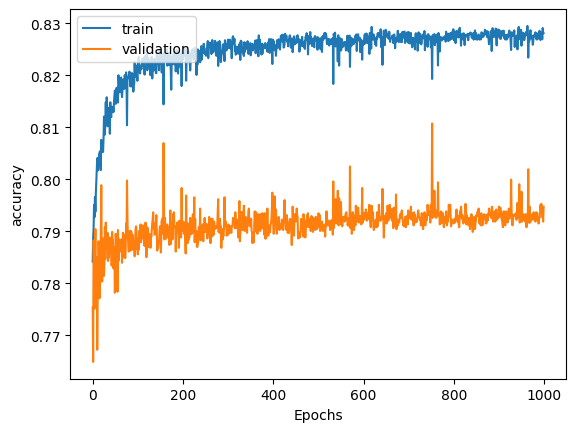

In [44]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('accuracy')